# Cross-conformal methods for classification

In this notebook, we estimate the impact of the training/calibration split on the
quantile estimate and then on the resulting coverage. 
To this end, we split our training dataset in K folds and
sequentially use each fold as a calibration set, the K-1 folds
remaining folds are used for training the base model using
the ``cv="prefit"`` option of
:class:`mapie.classification.MapieClassifier`.

We then adopt a cross-conformal approach in which the conformity scores of all calibration sets are used to estimate the quantile.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
%load_ext autoreload
%autoreload 2
%matplotlib inline

## I. Estimating the impact of train/calib split on the prediction sets

### Data generation

In [2]:
# Create training set from multivariate normal distribution
centers = [(0, 3.5), (-2, 0), (2, 0)]
covs = [[[1, 0], [0, 1]], [[2, 0], [0, 2]], [[5, 0], [0, 1]]]
x_min, x_max, y_min, y_max, step = -5, 7, -5, 7, 0.1
n_samples = 500
n_classes = 3
n_cv = 5
np.random.seed(42)
X_train = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
y_train = np.hstack([np.full(n_samples, i) for i in range(n_classes)])


In [3]:
# Create test from (x, y) coordinates
X_test_distrib = np.vstack([
    np.random.multivariate_normal(center, cov, 10*n_samples)
    for center, cov in zip(centers, covs)
])
y_test_distrib = np.hstack([np.full(10*n_samples, i) for i in range(n_classes)])
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step), np.arange(x_min, x_max, step)
)
X_test = np.stack([xx.ravel(), yy.ravel()], axis=1)

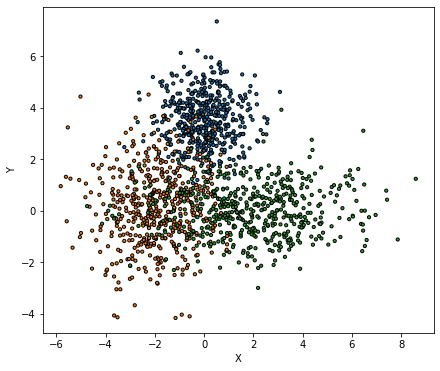

In [4]:
colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3: "#d62728"}
y_train_col = list(map(colors.get, y_train))
fig = plt.figure(figsize=(7, 6))
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    color=y_train_col,
    marker="o",
    s=10,
    edgecolor="k",
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Estimating predictions sets 

We split our training dataset into 5 folds and use each fold as a calibration set. Each calibration set is therefore used to estimate the conformity scores and the given quantiles for the two methods implemented in `MapieClassifier`. 

In [5]:
# Train the model and calibrate the score on each fold
kf = KFold(n_splits=5, shuffle=True)
clfs, mapies, y_preds, y_ps_mapies = {}, {}, {}, {}
methods = ["score", "cumulated_score"]
alpha = np.arange(0.01, 1, 0.01)
for method in methods:
    clfs2, mapies2, y_preds2, y_ps_mapies2 = {}, {}, {}, {}
    for i, (train_index, calib_index) in enumerate(kf.split(X_train)):
        clf = GaussianNB().fit(X_train[train_index], y_train[train_index])
        clfs2[i] = clf
        mapie = MapieClassifier(estimator=clf, cv="prefit", method=method)
        mapie.fit(X_train[calib_index], y_train[calib_index])
        mapies2[i] = mapie
        y_pred_mapie, y_ps_mapie = mapie.predict(
            X_test_distrib, alpha=alpha, include_last_label=True
        )
        y_preds2[i], y_ps_mapies2[i] = y_pred_mapie, y_ps_mapie
    clfs[method], mapies[method], y_preds[method], y_ps_mapies[method] = (
        clfs2, mapies2, y_preds2, y_ps_mapies2
    )

prefit
prefit
prefit
prefit
prefit
prefit
prefit
prefit
prefit
prefit


Let's now plot the distribution of conformity scores for each calibration set and the estimated quantile for `alpha` = 0.1.

Text(0.5, 1.04, 'Distribution of scores on each calibration fold for the score method')

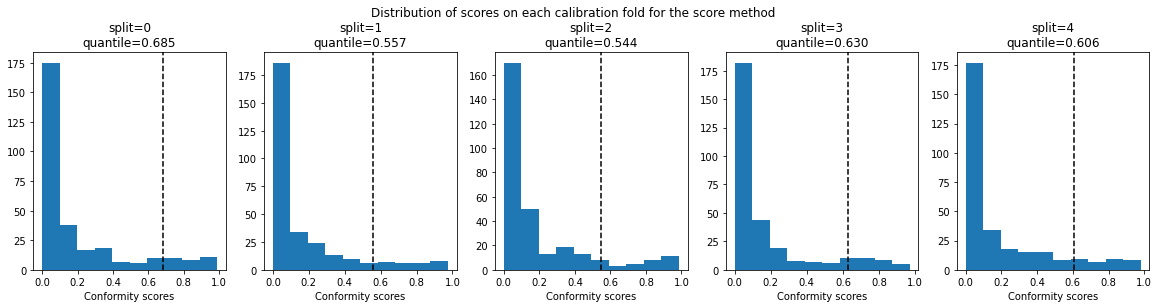

In [6]:
# Plot the distribution of scores on each calibration fold
fig, axs = plt.subplots(1, len(mapies["score"]), figsize=(20, 4))
for i, (key, mapie) in enumerate(mapies["score"].items()):
    axs[i].set_xlabel("Conformity scores")
    axs[i].hist(mapie.conformity_scores_)
    axs[i].axvline(mapie.quantiles_[9], ls="--", color="k")
    axs[i].set_title(f"split={key}\nquantile={mapie.quantiles_[9]:.3f}")
plt.suptitle(f"Distribution of scores on each calibration fold for the {methods[0]} method", y=1.04)


Text(0.5, 1.04, 'Distribution of scores on each calibration fold for the cumulated_score method')

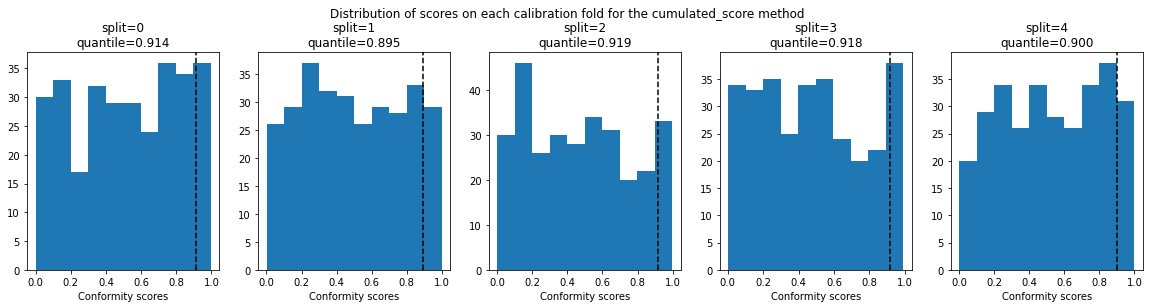

In [7]:
fig, axs = plt.subplots(1, len(mapies["score"]), figsize=(20, 4))
for i, (key, mapie) in enumerate(mapies["cumulated_score"].items()):
    axs[i].set_xlabel("Conformity scores")
    axs[i].hist(mapie.conformity_scores_)
    axs[i].axvline(mapie.quantiles_[9], ls="--", color="k")
    axs[i].set_title(f"split={key}\nquantile={mapie.quantiles_[9]:.3f}")
plt.suptitle(f"Distribution of scores on each calibration fold for the {methods[1]} method", y=1.04)

We notice that the estimated quantile slightly varies among the calibration sets for the two methods explored here, suggesting that the train/calibration splitting can slightly impact our results.

Let's now visualize this impact on the number of labels included in each prediction set induced by the different calibration sets. 

In [8]:
# Plot the number of labels
def plot_results(mapies, X_test, X_test2, y_test2, alpha, method):
    tab10 = plt.cm.get_cmap('Purples', 4)
    fig, axs = plt.subplots(1, len(mapies), figsize=(20, 4))
    for i, (key, mapie) in enumerate(mapies.items()):
        y_pi_sums = mapie.predict(X_test, alpha=alpha, include_last_label=False)[1][:, :, 0].sum(axis=1)
        num_labels = axs[i].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3
        )
        cbar = plt.colorbar(num_labels, ax=axs[i])
        # axs[i].set_title(f"split={key}\nquantile={mapies[key].quantiles_[0]:.3f}")
        coverage = classification_coverage_score(
            y_test2, mapie.predict(X_test2, alpha=alpha)[1][:, :, 0]
        )
        plt.suptitle(f"Number of labels in prediction sets for the {method} method", y=1.04)
        axs[i].set_title(f"coverage = {coverage:.3f}")


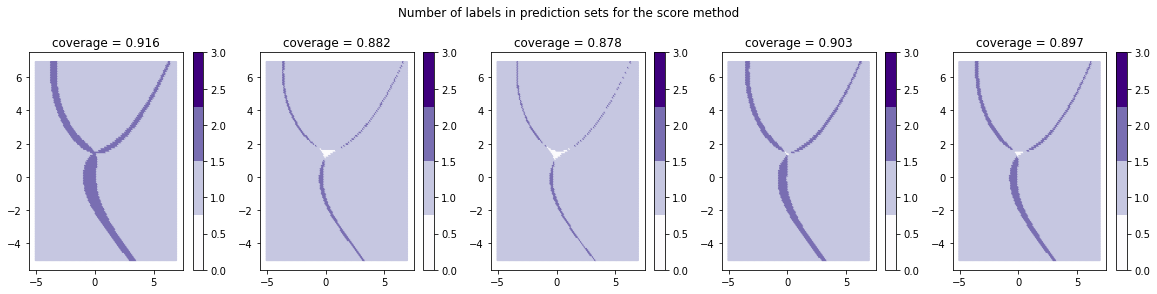

In [9]:
plot_results(mapies["score"], X_test, X_test_distrib, y_test_distrib, alpha[9], "score")

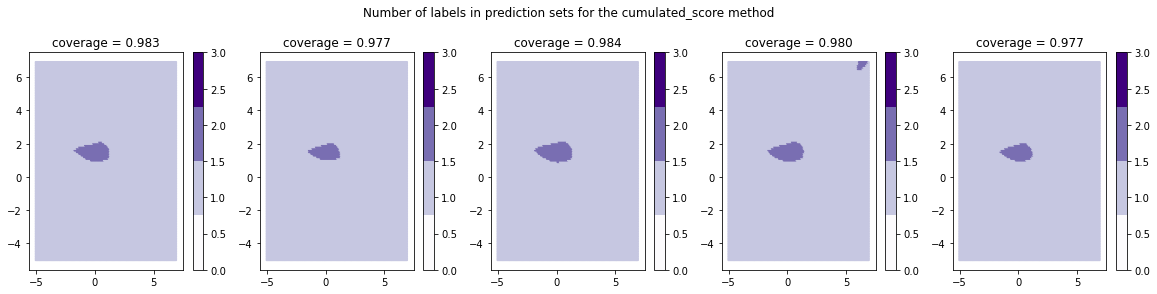

In [10]:
plot_results(mapies["cumulated_score"], X_test, X_test_distrib, y_test_distrib, alpha[9], "cumulated_score")

### Comparing the coverages and widths

Let's now visualize the coverage score and the prediction set size as function of the `alpha` parameter.

In [11]:
coverages = np.array(
    [
        [
            [classification_coverage_score(y_test_distrib, y_ps[:, :, ia]) for ia, _ in enumerate(alpha)]
            for _, y_ps in y_ps2.items()
        ] for _, y_ps2 in y_ps_mapies.items()
    ]
)
widths = np.array(
    [
        [
            [y_ps[:, :, ia].sum(axis=1).mean() for ia, _ in enumerate(alpha)]
            for _, y_ps in y_ps2.items()
        ] for _, y_ps2 in y_ps_mapies.items()
    ]
)

In [12]:
def plot_coverage_width(alpha, coverages, widths):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    axes[0].set_xlabel("1 - alpha")
    axes[0].set_ylabel("Effective coverage")
    for i, cov in enumerate(coverages):
        axes[0].plot(1-alpha, cov, label=f"Split {i+1}")
    axes[0].plot([0, 1], [0, 1], ls="--", color="k")
    axes[0].legend()
    axes[1].set_xlabel("1 - alpha")
    axes[1].set_ylabel("Average of prediction set sizes")
    for i, width in enumerate(widths):
        axes[1].plot(1-alpha, width, label=f"Split {i+1}")
    axes[1].legend()

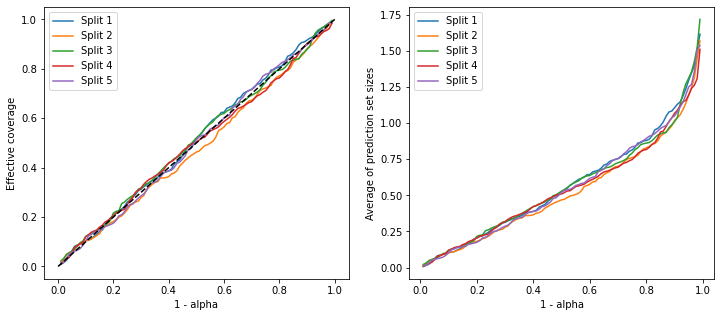

In [13]:
plot_coverage_width(alpha, coverages[0], widths[0])

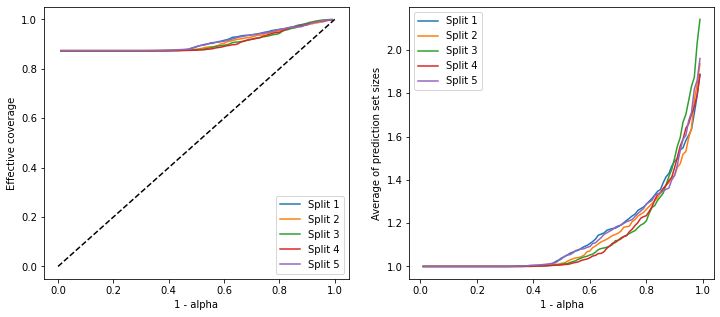

In [14]:
plot_coverage_width(alpha, coverages[1], widths[1])

One can notice that the train/calibration indeed impacts the coverage and prediction set. 

In conclusion, the split-conformal method has two main limitations:
- It prevents us to use the whole training set for training our base model
- The prediction sets are impacted by the way we extract the calibration set

## II. Aggregating the conformity scores through cross-validation

It is possible to "aggregate" the predictions through cross-validation mainly via two methods:
1. Aggregating the conformity scores for all training points and then simply averaging the score for a new test point
2. Comparing individually the conformity scores of the training points with the conformity scores from the associated model for a new test point (as presented for instance in Romano et al. 2020)

Let's explore the two possibilites with the "score" method.

In [15]:
X_trains = np.array([X_train[train_index] for train_index, calib_index in kf.split(X_train)])
X_calibs = np.array([X_train[calib_index] for train_index, calib_index in kf.split(X_train)])
y_trains = np.array([y_train[train_index] for train_index, calib_index in kf.split(y_train)])
y_calibs = np.array([y_train[calib_index] for train_index, calib_index in kf.split(y_train)])
n = len(y_train)/5

As in `MapieRegressor` we attribute to each training point the corresponding "leave-one-model" model, i.e. the perturbed model training on the subset of the data which does not include the given training point.

In [16]:
k_ = np.empty_like(y_train, dtype=int)
conf_scores = np.empty_like(y_train, dtype=float)
y_pred_probas, y_pred_proba_distribs = [], []
y_pred_probas_k = np.zeros((len(y_train), len(X_test), 3))
y_pred_proba_distribs_k = np.zeros((len(y_train), len(X_test_distrib), 3))
for i, (train_index, calib_index) in enumerate(kf.split(X_train)):
    k_[calib_index] = i
    conf_scores[calib_index] = mapies["score"][i].conformity_scores_.ravel()
    y_pred_proba_distribs.append(mapies["score"][i].single_estimator_.predict_proba(X_test_distrib))
    y_pred_probas.append(mapies["score"][i].single_estimator_.predict_proba(X_test))
    y_pred_probas_k[calib_index] = y_pred_probas[-1]
    y_pred_proba_distribs_k[calib_index] = y_pred_proba_distribs[-1]
y_pred_proba_mean = np.array(y_pred_probas).mean(axis=0)
y_pred_proba_distrib_mean = np.array(y_pred_proba_distribs).mean(axis=0)
y_pred_probas = np.array(y_pred_probas)

### Probability average

In this first method, we simply aggregate all the conformity scores on the whole training observations and use them to estimate the associated quantile for a given alpha. We then estimate the mean of the probabilities estimated by all models for new test observations and compare them with the quantile to estimate which label will be included in the prediction sets.

In [17]:
n = len(y_train)
quantiles_cv = np.quantile(conf_scores, ((n + 1) * (1 - alpha)) / n, interpolation="higher")

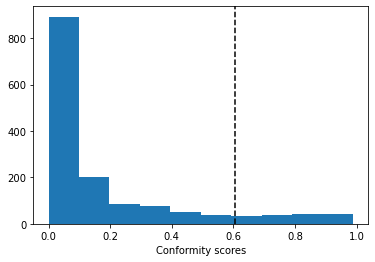

In [18]:
plt.hist(conf_scores)
plt.xlabel("Conformity scores")
plt.axvline(quantiles_cv[9], ls="--", color="k")

In [19]:
y_ps_cv = np.stack(
    [
        y_pred_proba_mean > 1 - quantile
        for quantile in quantiles_cv
    ],
    axis=2,
)
y_ps_distrib_cv = np.stack(
    [
        y_pred_proba_distrib_mean > 1 - quantile
        for quantile in quantiles_cv
    ],
    axis=2,
)

Let's now visualize the number of labels included in the prediction sets and the calibration plot.

Text(0.5, 1.0, 'coverage = 0.896')

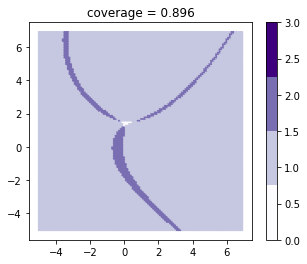

In [20]:
# Plot the number of labels
tab10 = plt.cm.get_cmap('Purples', 4)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
y_pred_col = [colors[int(i)] for _, i in enumerate(y_pred_mapie)]
y_train_col = [colors[int(i)] for _, i in enumerate(y_train)]
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
y_pi_sums = y_ps_cv[:, :, 9].sum(axis=1)
num_labels = axs.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_pi_sums,
    marker='.',
    s=10,
    alpha=1,
    cmap=tab10,
    vmin=0,
    vmax=3
)
cbar = plt.colorbar(num_labels, ax=axs)
# axs[i].set_title(f"split={key}\nquantile={mapies[key].quantiles_:.3f}")
coverage = classification_coverage_score(
    y_test_distrib, y_ps_distrib_cv[:, :, 9]
)
axs.set_title(f"coverage = {coverage:.3f}")

In [21]:
coverages_cv = np.array([classification_coverage_score(y_test_distrib, y_ps_distrib_cv[:, :, ia]) for ia, _ in enumerate(alpha)])
widths_cv = np.array([y_ps_distrib_cv[:, :, ia].sum(axis=1).mean() for ia, _ in enumerate(alpha)])

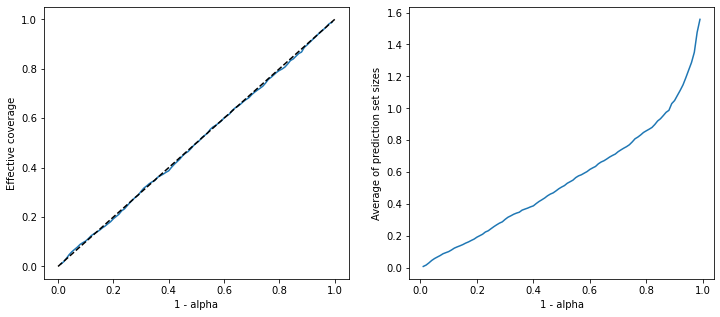

In [22]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].set_xlabel("1 - alpha")
axes[0].set_ylabel("Effective coverage")
axes[0].plot(1-alpha, coverages_cv)
axes[0].plot([0, 1], [0, 1], ls="--", color="k")
axes[1].set_xlabel("1 - alpha")
axes[1].set_ylabel("Average of prediction set sizes")
axes[1].plot(1-alpha, widths_cv)

The calibration plot looks much better than before ! Aggregating the scores through cross-validation seems to result in robust coverages since it no longer relies on the calibration/training split choice.

### CV+ / Jackknife+

In [23]:
confscores_calib = np.random.normal(0.5, 0.1, 1000)
confscores_test = np.arange(0, 1, 0.01)
alpha_confscores = 0.1
quantile_confscores = np.quantile(confscores_calib, 1 - alpha_confscores)

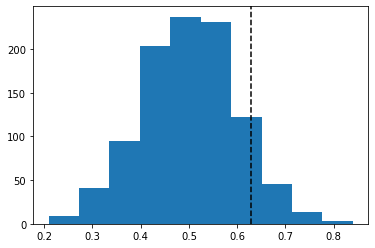

In [24]:
plt.hist(confscores_calib)
plt.axvline(quantile_confscores, ls="--", color="k")

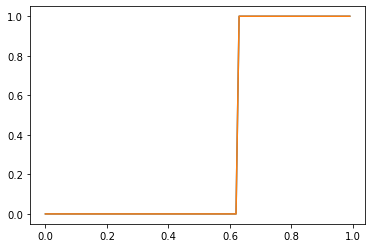

In [25]:
comp_scores_1 = confscores_test > quantile_confscores
comp_scores_2 = np.array([(p > confscores_calib).sum() for p in confscores_test]) > (1-alpha_confscores)*len(confscores_calib)

plt.plot(confscores_test, comp_scores_1)
plt.plot(confscores_test, comp_scores_2)

#### The CV+ method: individual comparison of the training conformity scores and their predictions from their corresponding "leave-one-out" model

In this second method, we follow the algorithm suggested by Romano et al. (2020) but for the score method. It follows the CV+ strategy already introduced by Foygel-Barber for regression. In short, for a new test observation, we compare the conformity scores of each training point and the score of the test point estimated by the corresponding model (i.e. the one that did not see the training point). We then compare the number of times the inequality is verified with $(n+1) \times \alpha$ to estimate if the label is included in the prediction set.

In [26]:
predsets_ind = []
for i, (train_index, calib_index) in enumerate(kf.split(X_train)):
    n_ = len(calib_index)
    clf_ = clfs["score"][i]
    mapie_ = mapies["score"][i]
    probas = clf_.predict_proba(X_test)
    tmp = (1 - probas < mapie_.conformity_scores_[:, None]).sum(axis=0)
    predsets_ind.append(np.array([tmp > ((n_ + 1) * (alpha[9]))])[0, :, :])

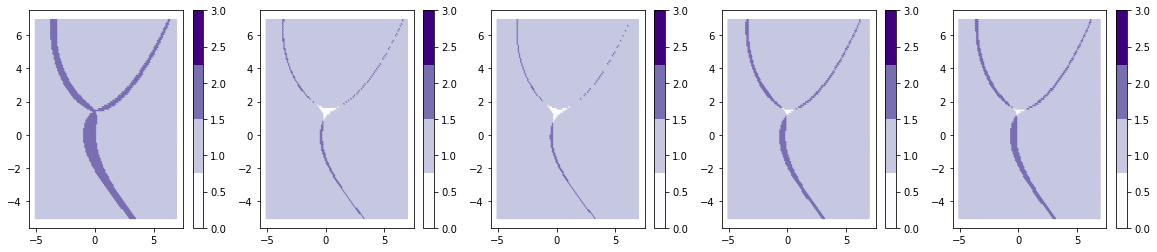

In [27]:
tab10 = plt.cm.get_cmap('Purples', 4)
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, (train_index, calib_index) in enumerate(kf.split(X_train)):
    y_pi_sums = predsets_ind[i].sum(axis=1)
    num_labels = axs[i].scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_pi_sums,
        marker='.',
        s=10,
        alpha=1,
        cmap=tab10,
        vmin=0,
        vmax=3
    )
    cbar = plt.colorbar(num_labels, ax=axs[i])

In [28]:
comp_cv = (1 - y_pred_probas_k < conf_scores[:, None, None]).sum(axis=0)
comp_distrib_cv = (1 - y_pred_proba_distribs_k < conf_scores[:, None, None]).sum(axis=0)
y_ps_cv_2 = np.stack([comp_cv > ((n + 1) * alpha_) for alpha_ in alpha], axis=2)
y_ps_distrib_cv_2 = np.stack([comp_distrib_cv > ((n + 1) * alpha_) for alpha_ in alpha], axis=2)

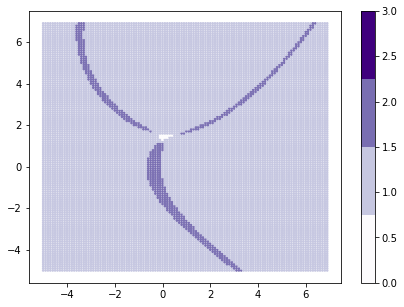

In [29]:
tab10 = plt.cm.get_cmap('Purples', 4)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
y_pi_sums = y_ps_cv_2[:, :, 9].sum(axis=1)
num_labels = axs.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_pi_sums,
    marker='.',
    s=10,
    alpha=1,
    cmap=tab10,
    vmin=0,
    vmax=3
)
cbar = plt.colorbar(num_labels, ax=axs)

In [30]:
coverages_cv_2 = np.array([classification_coverage_score(y_test_distrib, y_ps_distrib_cv_2[:, :, ia]) for ia, _ in enumerate(alpha)])
widths_cv_2 = np.array([y_ps_distrib_cv_2[:, :, ia].sum(axis=1).mean() for ia, _ in enumerate(alpha)])

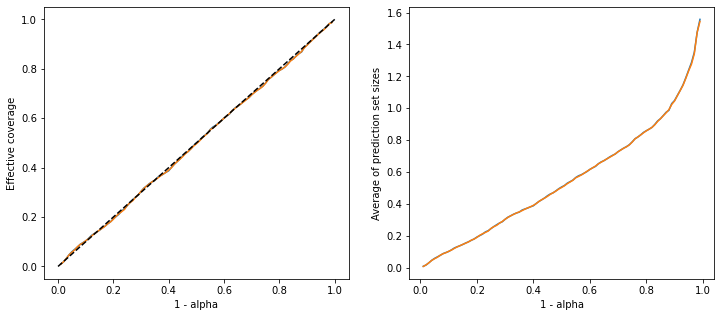

In [31]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].set_xlabel("1 - alpha")
axes[0].set_ylabel("Effective coverage")
axes[0].plot(1-alpha, coverages_cv)
axes[0].plot(1-alpha, coverages_cv_2)
axes[0].plot([0, 1], [0, 1], ls="--", color="k")
axes[1].set_xlabel("1 - alpha")
axes[1].set_ylabel("Average of prediction set sizes")
axes[1].plot(1-alpha, widths_cv)
axes[1].plot(1-alpha, widths_cv_2)

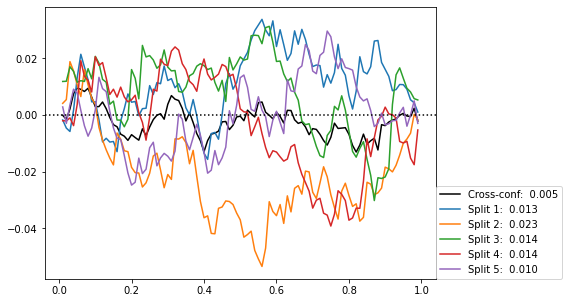

In [32]:
plt.figure(figsize=(7, 5))
plt.plot(1-alpha, coverages_cv - (1-alpha), color="k", label=f"Cross-conf: {np.abs(coverages_cv - (1-alpha)).mean(): .3f}")
for i, cov in enumerate(coverages[0]):
    print()
    plt.plot(1-alpha, cov - (1-alpha), label=f"Split {i+1}: {np.abs(cov - (1-alpha)).mean(): .3f}")
plt.axhline(0, color="k", ls=":")
plt.legend(loc=[1, 0])

## III. The CV+ method in MAPIE

#### The "score" method

In [33]:
mapie_clf = MapieClassifier(estimator=clf, cv=kf, method="score")

In [34]:
mapie_clf.fit(X_train, y_train)

KFold(n_splits=5, random_state=None, shuffle=True)


MapieClassifier(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                estimator=GaussianNB())

In [35]:
_, y_ps_score = mapie_clf.predict(X_test, alpha=alpha)

(array([10., 10., 10., 10.,  9., 10., 10., 10., 10., 10.]),
 array([  15.01 ,  162.108,  309.206,  456.304,  603.402,  750.5  ,
         897.598, 1044.696, 1191.794, 1338.892, 1485.99 ]),
 <BarContainer object of 10 artists>)

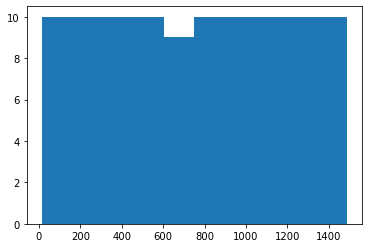

In [36]:
plt.hist(mapie_clf.quantiles_)

(array([887., 203.,  95.,  70.,  59.,  30.,  36.,  38.,  41.,  41.]),
 array([4.90913976e-11, 9.87263495e-02, 1.97452699e-01, 2.96179049e-01,
        3.94905398e-01, 4.93631747e-01, 5.92358097e-01, 6.91084446e-01,
        7.89810796e-01, 8.88537145e-01, 9.87263495e-01]),
 <BarContainer object of 10 artists>)

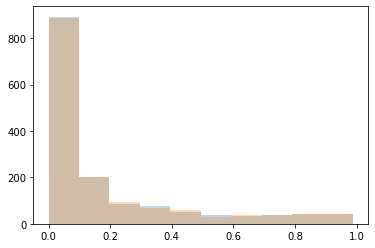

In [37]:
plt.hist(conf_scores, alpha=0.3)
plt.hist(mapie_clf.conformity_scores_, alpha=0.3)

In [38]:
y_probas_k = np.stack([est.predict_proba(X_test) for est in mapie_clf.estimators_])
y_pred_proba = np.array([y_probas_k[k] for k in mapie_clf.k_])

In [39]:
n = len(X_train)
y_comp = (1 - y_pred_proba < mapie_clf.conformity_scores_[:, None]).sum(axis=0)
pred_sets = np.stack([y_comp > ((n + 1) * alpha_) for alpha_ in alpha], axis=2)

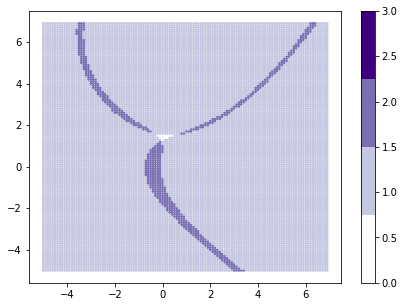

In [40]:
tab10 = plt.cm.get_cmap('Purples', 4)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
y_pi_sums = y_ps_score[:, :, 9].sum(axis=1)
num_labels = axs.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_pi_sums,
    marker='.',
    s=10,
    alpha=1,
    cmap=tab10,
    vmin=0,
    vmax=3
)
cbar = plt.colorbar(num_labels, ax=axs)

#### The "cumulated_score" method

In [55]:
mapie_clf = MapieClassifier(estimator=clf, cv=kf, method="cumulated_score")

In [56]:
mapie_clf.fit(X_train, y_train)

KFold(n_splits=5, random_state=None, shuffle=True)


MapieClassifier(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                estimator=GaussianNB(), method='cumulated_score')

(array([153., 146., 158., 160., 146., 160., 142., 153., 145., 137.]),
 array([0.0014776 , 0.10111643, 0.20075526, 0.30039409, 0.40003292,
        0.49967175, 0.59931058, 0.69894941, 0.79858824, 0.89822707,
        0.9978659 ]),
 <BarContainer object of 10 artists>)

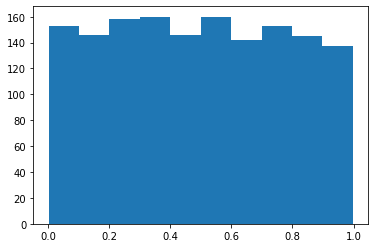

In [57]:
plt.hist(mapie_clf.conformity_scores_)

#### `agg_probas="mean"`

In [105]:
_, y_ps_cum_score = mapie_clf.predict(X_test, alpha=alpha, include_last_label=True, agg_probas="mean")

(14400, 3)


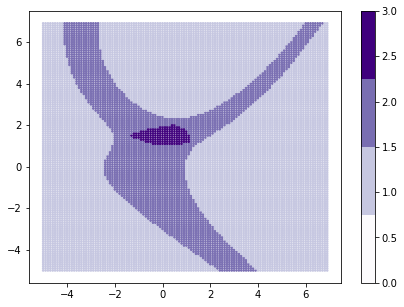

In [108]:
tab10 = plt.cm.get_cmap('Purples', 4)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
y_pi_sums = y_ps_cum_score[:, :, 9].sum(axis=1)
num_labels = axs.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_pi_sums,
    marker='.',
    s=10,
    alpha=1,
    cmap=tab10,
    vmin=0,
    vmax=3
)
cbar = plt.colorbar(num_labels, ax=axs)

In [109]:
_, y_ps_distrib_cum_score1 = mapie_clf.predict(X_test_distrib, alpha=alpha, include_last_label="randomized", agg_probas="mean")
_, y_ps_distrib_cum_score2 = mapie_clf.predict(X_test_distrib, alpha=alpha, include_last_label=False, agg_probas="mean")
_, y_ps_distrib_cum_score3 = mapie_clf.predict(X_test_distrib, alpha=alpha, include_last_label=True, agg_probas="mean")

In [101]:
coverages_cv_cum_score = np.array([classification_coverage_score(y_test_distrib, y_ps_distrib_cum_score[:, :, ia]) for ia, _ in enumerate(alpha)])
widths_cv_cum_score = np.array([y_ps_distrib_cum_score[:, :, ia].sum(axis=1).mean() for ia, _ in enumerate(alpha)])

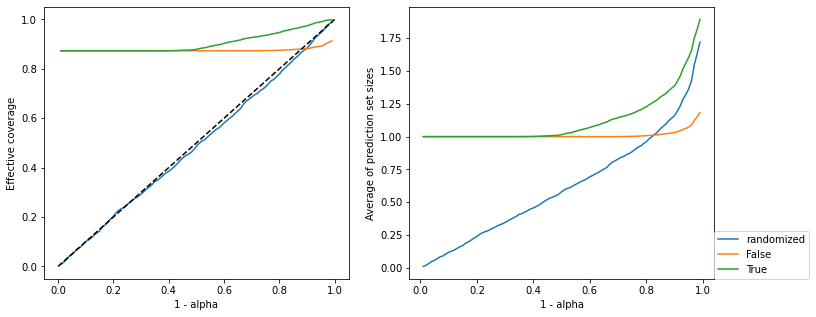

In [111]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].set_xlabel("1 - alpha")
axes[0].set_ylabel("Effective coverage")
for i, y_ps in enumerate([y_ps_distrib_cum_score1, y_ps_distrib_cum_score2, y_ps_distrib_cum_score3]):
    coverages_ = np.array([classification_coverage_score(y_test_distrib, y_ps[:, :, ia]) for ia, _ in enumerate(alpha)])
    axes[0].plot(1-alpha, coverages_)
axes[0].plot([0, 1], [0, 1], ls="--", color="k")
axes[1].set_xlabel("1 - alpha")
axes[1].set_ylabel("Average of prediction set sizes")
for i, y_ps in enumerate([y_ps_distrib_cum_score1, y_ps_distrib_cum_score2, y_ps_distrib_cum_score3]):
    widths_ = np.array([y_ps[:, :, ia].sum(axis=1).mean() for ia, _ in enumerate(alpha)])
    axes[1].plot(1-alpha, widths_)
axes[1].legend(["randomized", False, True], loc=[1, 0])


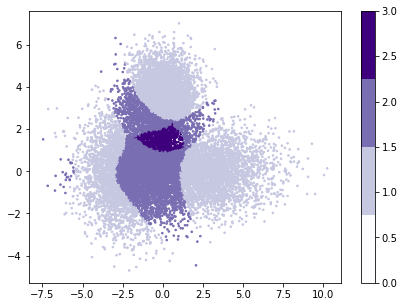

In [103]:
tab10 = plt.cm.get_cmap('Purples', 4)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
y_pi_sums = y_ps_distrib_cum_score_2[:, :, 9].sum(axis=1)
num_labels = axs.scatter(
    X_test_distrib[:, 0],
    X_test_distrib[:, 1],
    c=y_pi_sums,
    marker='.',
    s=10,
    alpha=1,
    cmap=tab10,
    vmin=0,
    vmax=3
)
cbar = plt.colorbar(num_labels, ax=axs)

#### `agg_probas="crossval"`

In [170]:
_, y_ps_cum_score = mapie_clf.predict(X_test, alpha=alpha, include_last_label=True, agg_probas="crossval")

y_pred_proba(0): [1.14919863e-18 9.99931647e-01 6.83527515e-05]
index_sorted(0): [1 2 0]
y_pred_proba_sorted(0): [9.99931647e-01 6.83527515e-05 1.14919863e-18]
y_pred_proba_sorted_cumsum(0): [0.99993165 1.         1.        ]
y_pred_proba_cumsum(0): [1.         0.99993165 1.        ]
0
y_pred_proba:  [1.14919863e-18 9.99931647e-01 6.83527515e-05]
conformity_scores_:  [0.72968015]
false
y_pred_index_last_:  1
y_pred_proba_last_:  [0.99993165]
prediction_sets_:  [ True False  True]
1
y_pred_proba:  [3.78812446e-19 9.99905409e-01 9.45906355e-05]
conformity_scores_:  [0.74299233]
false
y_pred_index_last_:  1
y_pred_proba_last_:  [0.99990541]
prediction_sets_:  [ True False  True]
2
y_pred_proba:  [7.13996610e-19 9.99950641e-01 4.93587087e-05]
conformity_scores_:  [0.76034648]
false
y_pred_index_last_:  1
y_pred_proba_last_:  [0.99995064]
prediction_sets_:  [ True False  True]
3
y_pred_proba:  [7.75448863e-19 9.99926372e-01 7.36281700e-05]
conformity_scores_:  [0.50235008]
false
y_pred_inde

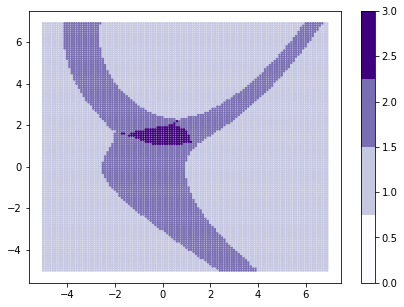

In [171]:
tab10 = plt.cm.get_cmap('Purples', 4)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
y_pi_sums = y_ps_cum_score[:, :, 9].sum(axis=1)
num_labels = axs.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_pi_sums,
    marker='.',
    s=10,
    alpha=1,
    cmap=tab10,
    vmin=0,
    vmax=3
)
cbar = plt.colorbar(num_labels, ax=axs)

In [184]:
_, y_ps_distrib_cum_score1 = mapie_clf.predict(X_test_distrib, alpha=alpha, include_last_label="randomized", agg_probas="crossval")
_, y_ps_distrib_cum_score2 = mapie_clf.predict(X_test_distrib, alpha=alpha, include_last_label=False, agg_probas="crossval")
_, y_ps_distrib_cum_score3 = mapie_clf.predict(X_test_distrib, alpha=alpha, include_last_label=True, agg_probas="crossval")

y_pred_proba(0): [0.46276135 0.5256858  0.01155285]
index_sorted(0): [1 0 2]
y_pred_proba_sorted(0): [0.5256858  0.46276135 0.01155285]
y_pred_proba_sorted_cumsum(0): [0.5256858  0.98844715 1.        ]
y_pred_proba_cumsum(0): [0.98844715 0.5256858  1.        ]
0
y_pred_proba:  [0.46276135 0.5256858  0.01155285]
conformity_scores_:  [0.72968015]
false
y_pred_index_last_:  0
y_pred_proba_last_:  [0.46276135]
prediction_sets_:  [False False  True]
(15000, 3) (15000,)
y_proba_last_cumsumed:  0.9884471466527764
vs:  0.5591802352005298 0.31916248514304135
(15000, 3) (15000,) (15000,)
[False False  True]
[False False  True]
-----
1
y_pred_proba:  [0.44638079 0.53952708 0.01409213]
conformity_scores_:  [0.74299233]
false
y_pred_index_last_:  0
y_pred_proba_last_:  [0.44638079]
prediction_sets_:  [False False  True]
(15000, 3) (15000,)
y_proba_last_cumsumed:  0.985907870984012
vs:  0.5441890577964911 0.6191318752569599
(15000, 3) (15000,) (15000,)
[False False  True]
[ True False  True]
-----
2

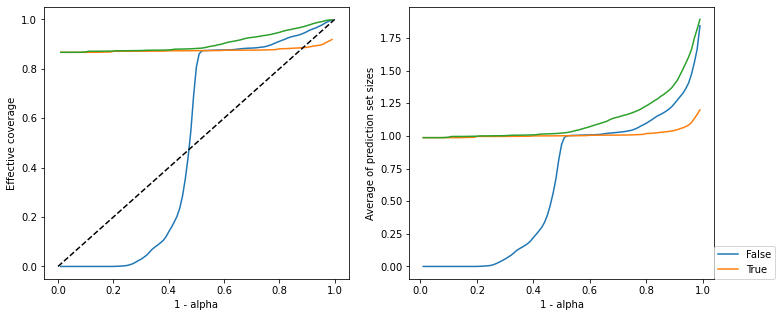

In [185]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].set_xlabel("1 - alpha")
axes[0].set_ylabel("Effective coverage")
for i, y_ps in enumerate([y_ps_distrib_cum_score1, y_ps_distrib_cum_score2, y_ps_distrib_cum_score3]): # 
    coverages_ = np.array([classification_coverage_score(y_test_distrib, y_ps[:, :, ia]) for ia, _ in enumerate(alpha)])
    axes[0].plot(1-alpha, coverages_)
axes[0].plot([0, 1], [0, 1], ls="--", color="k")
axes[1].set_xlabel("1 - alpha")
axes[1].set_ylabel("Average of prediction set sizes")
for i, y_ps in enumerate([y_ps_distrib_cum_score1, y_ps_distrib_cum_score2, y_ps_distrib_cum_score3]):
    widths_ = np.array([y_ps[:, :, ia].sum(axis=1).mean() for ia, _ in enumerate(alpha)])
    axes[1].plot(1-alpha, widths_)
axes[1].legend([False, True], loc=[1, 0]) # "randomized", 


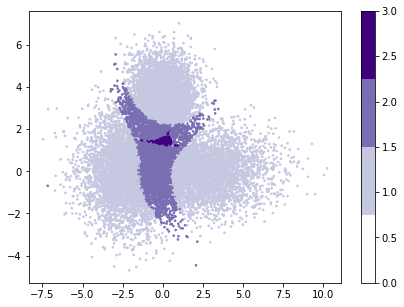

In [186]:
tab10 = plt.cm.get_cmap('Purples', 4)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
y_pi_sums = y_ps_distrib_cum_score1[:, :, 9].sum(axis=1)
num_labels = axs.scatter(
    X_test_distrib[:, 0],
    X_test_distrib[:, 1],
    c=y_pi_sums,
    marker='.',
    s=10,
    alpha=1,
    cmap=tab10,
    vmin=0,
    vmax=3
)
cbar = plt.colorbar(num_labels, ax=axs)

### 